In [2]:
sns.set_style('darkgrid')


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import json
import re
import string
import tqdm
# natural language toolkit library for stemming, tokenizing, etc.
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

In [25]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [3]:
columns = ['target', 'id', 'date', 'flag', 'user', 'text']


In [4]:
full_df = pd.read_csv(r'C:\Users\user\Desktop\academics\sem5\Machine Learning\project\training.1600000.processed.noemoticon.csv', header = None, names = columns,  encoding='latin-1')

In [5]:
full_df.head()


,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
num_tweets = len(full_df)
num_pos_tweets = len(full_df[full_df['target'] == 4])
num_neg_tweets = len(full_df[full_df['target'] == 0])
print("Total Number of tweets in the database = {}".format(num_tweets))
print("Total Number of positive tweets = {}".format(num_pos_tweets))
print("Total Number of negative tweets = {}".format(num_neg_tweets))

Total Number of tweets in the database = 1600000
Total Number of positive tweets = 800000
Total Number of negative tweets = 800000


In [7]:
#all_positive_tweets = full_df[full_df['target'] == 4]['text'].to_json()
#all_negative_tweets = full_df[full_df['target'] == 0]['text'].to_json()
#pos_file = open("data/pos_tweets.json", 'w')
#neg_file = open("data/neg_tweets.json", 'w')
#json.dump(all_positive_tweets, pos_file, indent = 6)
#json.dump(all_negative_tweets, neg_file, indent = 6)

In [8]:
all_positive_tweets = list(full_df[full_df['target'] == 4]['text'])
all_negative_tweets = list(full_df[full_df['target'] == 0]['text'])

In [9]:
# selecting only a portion of data due large size
select_prop = .25
all_positive_tweets = all_positive_tweets[:int(len(all_positive_tweets)*select_prop)]
all_negative_tweets = all_negative_tweets[:int(len(all_negative_tweets)*select_prop)]

In [10]:
train_split = 0.8
train_pos = all_positive_tweets[:int(len(all_positive_tweets)*train_split)]
train_neg = all_negative_tweets[:int(len(all_negative_tweets)*train_split)]
test_pos = all_positive_tweets[int(len(all_positive_tweets)*train_split):]
test_neg = all_negative_tweets[int(len(all_negative_tweets)*train_split):]
train_x = train_pos + train_neg
test_x = test_pos + test_neg
train_y = np.concatenate((np.ones(len(train_pos)), np.zeros(len(train_neg))))
test_y = np.concatenate((np.ones(len(test_pos)), np.zeros(len(test_neg))))


In [11]:
print("Positive tweet - ")
print(train_pos[0])
print("Negative tweet - ")
print(train_neg[12])

Positive tweet - 
I LOVE @Health4UandPets u guys r the best!! 
Negative tweet - 
@caregiving I couldn't bear to watch it.  And I thought the UA loss was embarrassing . . . . .


In [12]:
print("Number of training samples - ", len(train_x))
print("Numner of test samples - ", len(test_x))

Number of training samples -  320000
Numner of test samples -  80000


In [26]:
def process_tweet(tweet):
    """Process tweet function.
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet
    """
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    return tweets_clean

def build_freqs(tweets, ys):
    """Build frequencies.
    Input:
        tweets: a list of tweets
        ys: an m x 1 array with the sentiment label of each tweet
            (either 0 or 1)
    Output:
        freqs: a dictionary mapping each (word, sentiment) pair to its
        frequency
    """
    # Convert np array to list since zip needs an iterable.
    # The squeeze is necessary or the list ends up with one element.
    # Also note that this is just a NOP if ys is already a list.
    yslist = np.squeeze(ys).tolist()

    # Start with an empty dictionary and populate it by looping over all tweets
    # and over all processed words in each tweet.
    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs

In [27]:

print("Original Tweet - ")
print(train_x[0])
print("Processed Tweet - ")
print(process_tweet(train_x[0]))

Original Tweet - 
I LOVE @Health4UandPets u guys r the best!! 
Processed Tweet - 
['love', 'u', 'guy', 'r', 'best']


In [34]:
# Frequency dict
# structure
# (word, label) : number of times word appears in that class
freqs = build_freqs(train_x, train_y)

In [29]:
# sugmoid function
def sigmoid(z):
    h = 1/(1 + np.exp(-z))
    return h

# stochastic gradient descent algorithm for optimizing weigths

def StochasticGradientDescent(x, y, theta, alpha, num_iters, batch_per_itr, batch_size):
    '''
    Input:
        x: matrix of features which is (m,n+1)
        y: corresponding labels of the input matrix x, dimensions (m,1)
        theta: weight vector of dimension (n+1,1)
        alpha: learning rate
        num_iters: number of iterations you want to train your model for
    Output:
        J: the final cost
        theta: final weight vector
        
    '''
    # get 'm', the number of rows in matrix x
    m =  x.shape[0]
    loss = []
    for itr in range(0, num_iters):
        
        for i in range(batch_per_itr):
            batch = np.random.randint(0, m, size=batch_size)
            x_train = x[batch,:]
            y_train = y[batch,:]
            
            # get z, the dot product of x and theta
            z = np.dot(x_train, theta)
        
            # get the sigmoid of z
            h = sigmoid(z)
        
            # calculate the cost function
            J = -1/batch_size * (np.dot(np.transpose(y_train),np.log(h)) + np.dot(np.transpose(1 - y_train), np.log(1 - h)))
            
            
        
            # update the weights theta
            theta = theta - ( alpha/m * np.dot(np.transpose(x_train), (h - y_train)))
        if not itr%10 and itr:
            print("Completed {} iterations, loss = {}".format(itr, np.squeeze(J))) 
        loss.append(J)
    J = float(J)
    return J, theta, loss

# feature extraction utility function

def extract_features(tweet, freqs):
    '''
    Input: 
        tweet: a list of words for one tweet
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
    Output: 
        x: a feature vector of dimension (1,3)
    '''
    # process_tweet tokenizes, stems, and removes stopwords
    word_l = process_tweet(tweet)
    
    # 3 elements in the form of a 1 x 3 vector
    x = np.zeros((1, 3)) 
    
    #bias term is set to 1
    x[0,0] = 1 
    
    
    # loop through each word in the list of words
    for word in word_l:
        pos_pair = (word, 1.0)
        neg_pair = (word, 0.0)
        if pos_pair in freqs.keys():
            # increment the word count for the positive label 1
            x[0,1] += freqs[pos_pair]
        if neg_pair in freqs.keys():
            # increment the word count for the negative label 0
            x[0,2] += freqs[neg_pair]
        
        
    assert(x.shape == (1, 3))
    return x


def predict_tweet(tweet, freqs, theta):
    '''
    Input: 
        tweet: a string
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
        theta: (3,1) vector of weights
    Output: 
        y_pred: the probability of a tweet being positive or negative
    '''
    
    # extract the features of the tweet and store it into x
    x = extract_features(tweet, freqs)
    
    # make the prediction using x and theta
    y_pred = sigmoid(np.dot(x, theta))
    
    
    return y_pred


def test_logistic_regression(test_x, test_y, freqs, theta):
    """
    Input: 
        test_x: a list of tweets
        test_y: (m, 1) vector with the corresponding labels for the list of tweets
        freqs: a dictionary with the frequency of each pair (or tuple)
        theta: weight vector of dimension (3, 1)
    Output: 
        accuracy: (# of tweets classified correctly) / (total # of tweets)
    """
    

    
    # the list for storing predictions
    y_hat = []
    m = test_y.shape[0]
    for tweet in test_x:
        # get the label prediction for the tweet
        y_pred = predict_tweet(tweet, freqs, theta)
        
        if y_pred > 0.5:
            # append 1.0 to the list
            y_hat.append(1)
        else:
            # append 0 to the list
            y_hat.append(0)

   
   
    y_hat = np.array(y_hat)
    y_hat = np.reshape(y_hat, (m, 1))
    accuracy = np.sum(y_hat == test_y)/m
    
    return accuracy

In [30]:
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :]= extract_features(train_x[i], freqs)
 

Y = train_y

In [31]:
Y = np.reshape(Y, (-1,1))


In [32]:
# shuffle data
s = np.random.permutation(range(len(X)))
X = X[s]
Y = Y[s]

In [33]:
J, theta, loss_logs = StochasticGradientDescent(X, Y, theta = np.zeros((3, 1)), alpha=1e-9, num_iters=100, batch_per_itr=50, batch_size=100000) 
print(f"The cost after traill ning is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(theta)]}")

Completed 10 iterations, loss = 0.6334410745843622
Completed 20 iterations, loss = 0.6188409104630113
Completed 30 iterations, loss = 0.6128375695256166
Completed 40 iterations, loss = 0.6101830173476401
Completed 50 iterations, loss = 0.6080128046992808
Completed 60 iterations, loss = 0.6062575738492373
Completed 70 iterations, loss = 0.6076723167736039
Completed 80 iterations, loss = 0.6064011806728571
Completed 90 iterations, loss = 0.6059654746544123
The cost after traill ning is 0.60591551.
The resulting vector of weights is [-0.0, 0.00018306, -0.00015833]


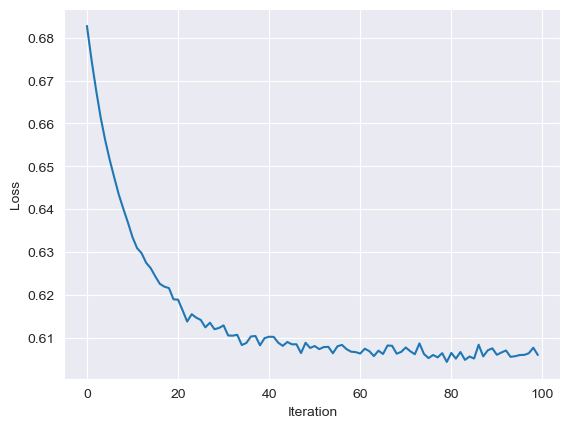

In [35]:
plt.plot(np.squeeze(loss_logs))
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [36]:
tmp_accuracy = test_logistic_regression(test_x, np.reshape(test_y, (-1,1)), freqs, theta)
print(f"Logistic regression model's accuracy = {tmp_accuracy:.4f}")

Logistic regression model's accuracy = 0.6810
